In [10]:
from nimlab import datasets as nimds
import numpy as np
from nilearn import image, plotting, maskers
import nibabel as nib
import os
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

## Identify Niftis to Use as Maps
### Organize Maps for Utilization in a Folder

In [2]:
#User Input Below
map_dir = r'/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/arb_folder'
file_pattern  = '*.nii'
analysis = "addbs_r_map_to_ferguson_specificity_map_agreement_map"

html_dir = r'/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/html_networks'
agree_dir = r'/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/agreement_networks'

In [3]:
glob_path = os.path.join(map_dir, file_pattern)
print('Path: ', glob_path)
globbed = glob.glob(glob_path)
for i in range(0, len(globbed)):
    print(f'Nifti {i} found: ', globbed[i])


Path:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/arb_folder/*.nii
Nifti 0 found:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/arb_folder/Fx-DBS-Network_N46.nii
Nifti 1 found:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/arb_folder/ferguson_amnesia_specificity_map_t_matrix.nii


In [4]:
#Use the above matrix output to design you correlation vector
#Example: >65 improves with connection to ventral attention, which is 0 above, and impaired with conenction to limbic, which is 1 above, therefore:
#correlation_vector = [1, -1]
# memory = -1
# visual = -1
# soma = +1
# dors = +1
# vent = +1
# limb = -1
# frontop = +1
# defa = -1

#-----Make sure the input list is in the same order as the paths above------#
# correlation_vector = [memory, visual, soma, dors, vent, limb, frontop, defa]
correlation_vector = [1, 1] #[visual, soma, dors, vent, limb, frontop, defa] 
#This is a vector of 1s with sign indicating how conenctivity to the network impacts outcomes.


In [5]:
#Access and display nifti 1 
mni_mask = nimds.get_img("mni_icbm152")
matrix_dict = {}
for i in range(0, len(globbed)):
    matrix_dict.update({str(i): image.load_img(globbed[i])})
print(f'Dict is {len(matrix_dict)} units long, or has a final index at {len(matrix_dict)-1}')

Dict is 2 units long, or has a final index at 1


In [6]:
def agreement_creator(matrix_dict, correlation_vector):
        positive_matrix = np.ones(matrix_dict[str(0)].shape)
        negative_matrix = np.ones(matrix_dict[str(0)].shape)
        agreement_matrix = np.ones(matrix_dict[str(0)].shape)
        for i in range(0, len(matrix_dict)):
            try:
                #Prepare the Matrices
                matrix_one = matrix_dict[str(i)].get_fdata() #inputs matrix to numpy array
                matrix_one = np.nan_to_num(matrix_one, nan=0, posinf=0, neginf=0) #cleans matrix
                matrix_one = matrix_one*correlation_vector[i] #Sets the values in relation to clinical outcome
                matrix_two = matrix_dict[str(i+1)].get_fdata()
                matrix_two = np.nan_to_num(matrix_two, nan=0, posinf=0, neginf=0)
                matrix_two = matrix_two*correlation_vector[i+1]

                #Find the signs of all values in the matrices and binarize them
                positive_matrix_one = np.zeros(matrix_dict[str(0)].shape); positive_matrix_two = np.zeros(matrix_dict[str(0)].shape); 
                negative_matrix_one = np.zeros(matrix_dict[str(0)].shape); negative_matrix_two = np.zeros(matrix_dict[str(0)].shape)
                positive_matrix_one[matrix_one>0] = 1; positive_matrix_two[matrix_two>0] = 1 
                negative_matrix_one[matrix_one<0] = -1; negative_matrix_two[matrix_two<0] = -1
                positive_matrix = positive_matrix*(positive_matrix_one*positive_matrix_two) #finds all regions that positively affect clinical outcome, then stores these in positive_matrix
                negative_matrix = -1*(abs(negative_matrix)*(negative_matrix_one*negative_matrix_two)) #finds all regions that negatively affect clinical outcome, then stores these in negative_matrix
                
                #Creates Normalized Agreement Matrix
                multiplied_matrix = (matrix_one/np.max(abs(matrix_one)))*(matrix_two/np.max(abs(matrix_two))) #Normalizes component matrices and multiplies them, merging to one
                normalized_matrix = multiplied_matrix/np.max(abs(multiplied_matrix)) #Normalizes the above matrix
                masked_matrix = normalized_matrix*(positive_matrix+negative_matrix) #Masks the matrix, removing disagreeing values, sets positive and negative values
                agreement_matrix = agreement_matrix*masked_matrix #This stores the masked normalized agreement matrix component
            except:
                print('no second matrix to measure, all done')
        binary_matrix = negative_matrix + positive_matrix
        return binary_matrix, agreement_matrix


binarized_matrix, agreement_matrix = agreement_creator(matrix_dict=matrix_dict, correlation_vector=correlation_vector)

agreement = np.count_nonzero(binarized_matrix)/np.count_nonzero(mni_mask.get_fdata())
print('---Sanity Check---')
print('nonzero values, normalized matrix: ', np.count_nonzero(agreement_matrix))
print('nonzero values, binary matrix: ', np.count_nonzero(binarized_matrix))
print('Percent spatial agreement: ', agreement*100)

no second matrix to measure, all done
---Sanity Check---
nonzero values, normalized matrix:  134610
nonzero values, binary matrix:  134610
Percent spatial agreement:  59.767695873404904


Fx-DBS-Network_N46.nii



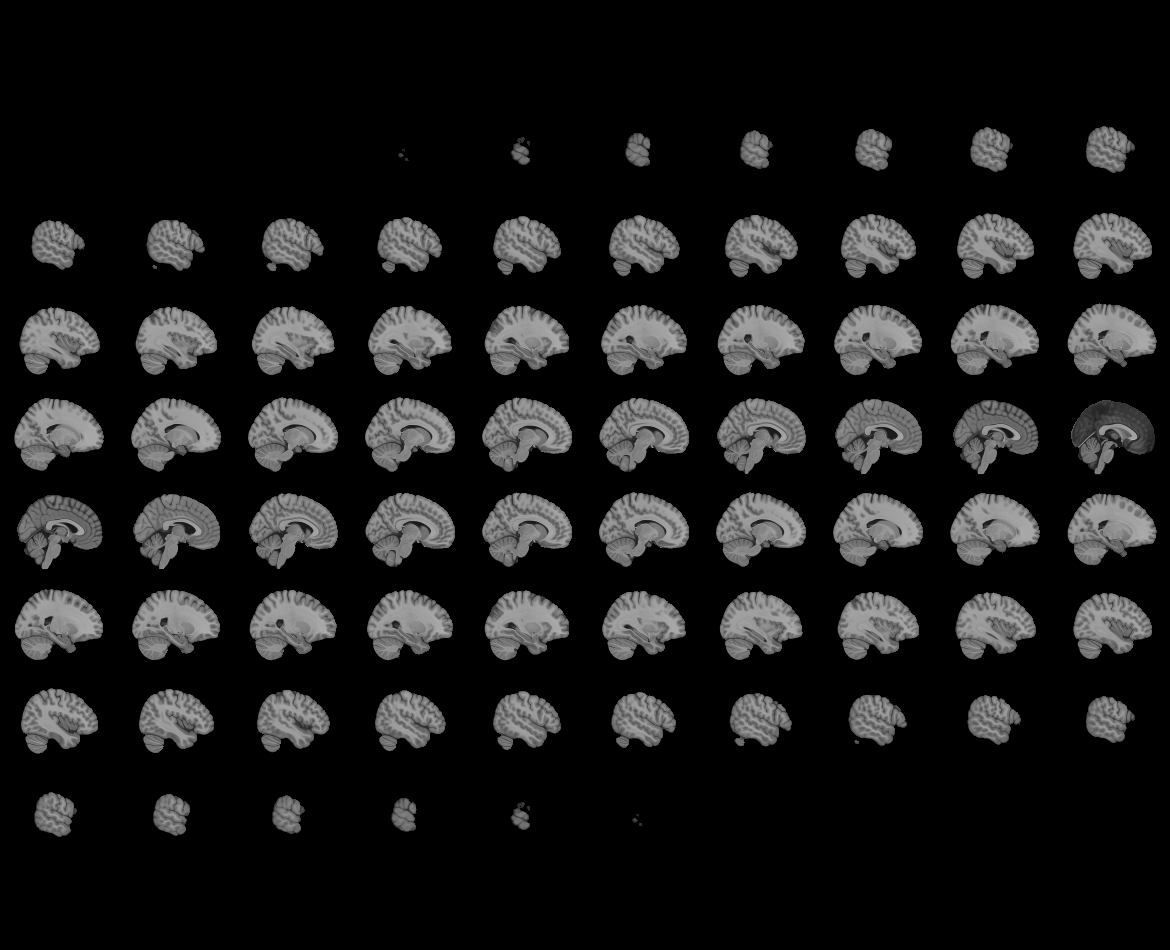
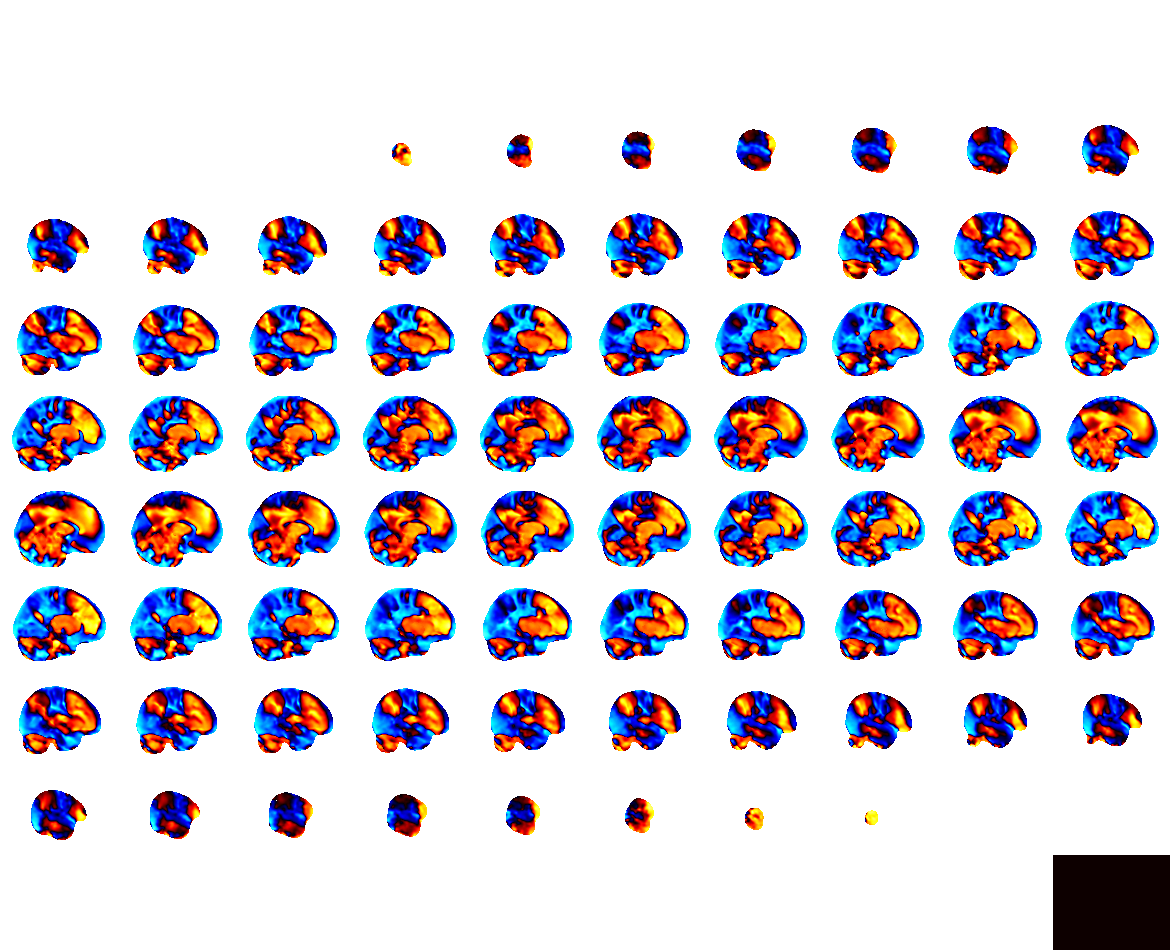

In [15]:
#For visual corroboration of the agreement matrix, plot as many component matrices as necessary
htlm_one = plotting.view_img(matrix_dict[str(0)], cut_coords=(0,0,0), opacity=.75)
print(os.path.basename(globbed[0]))
htlm_one

ferguson_amnesia_specificity_map_t_matrix.nii



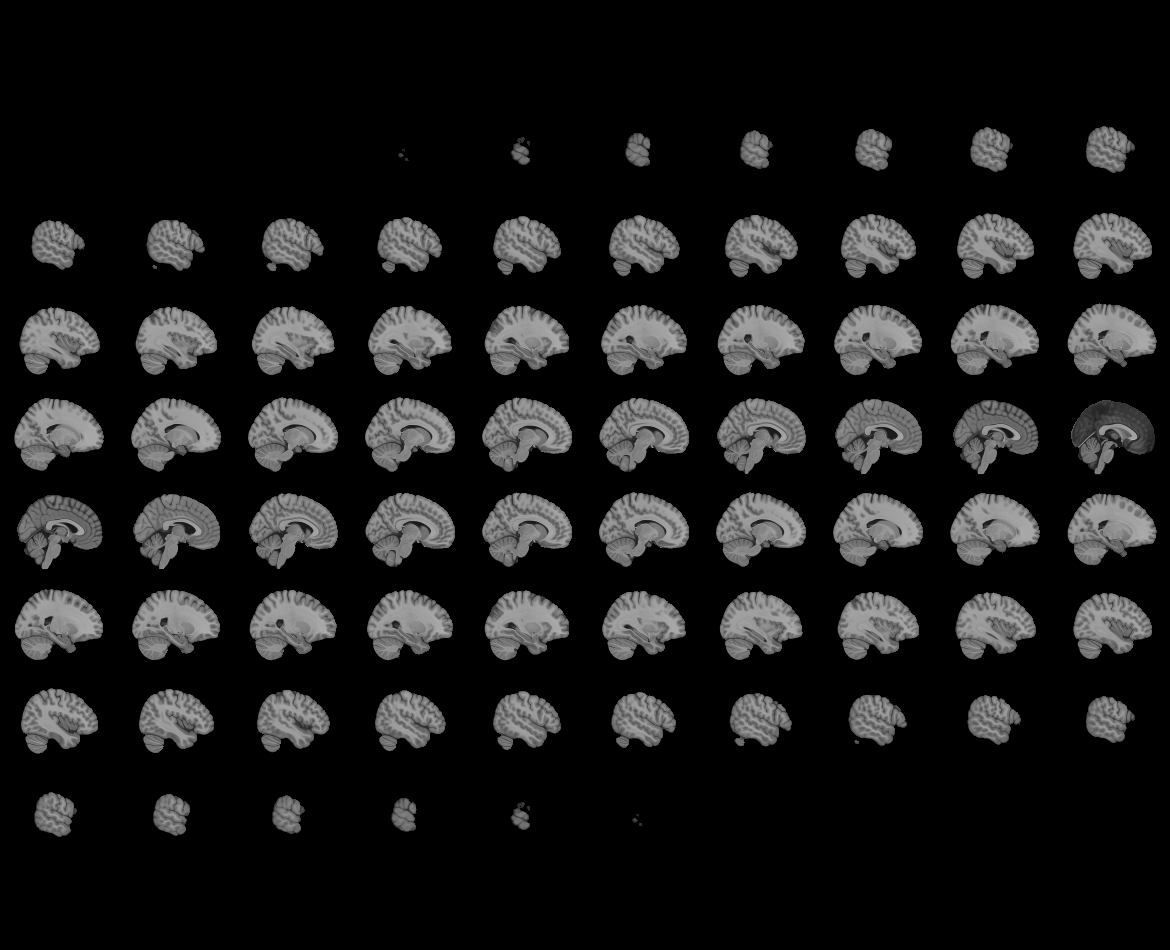
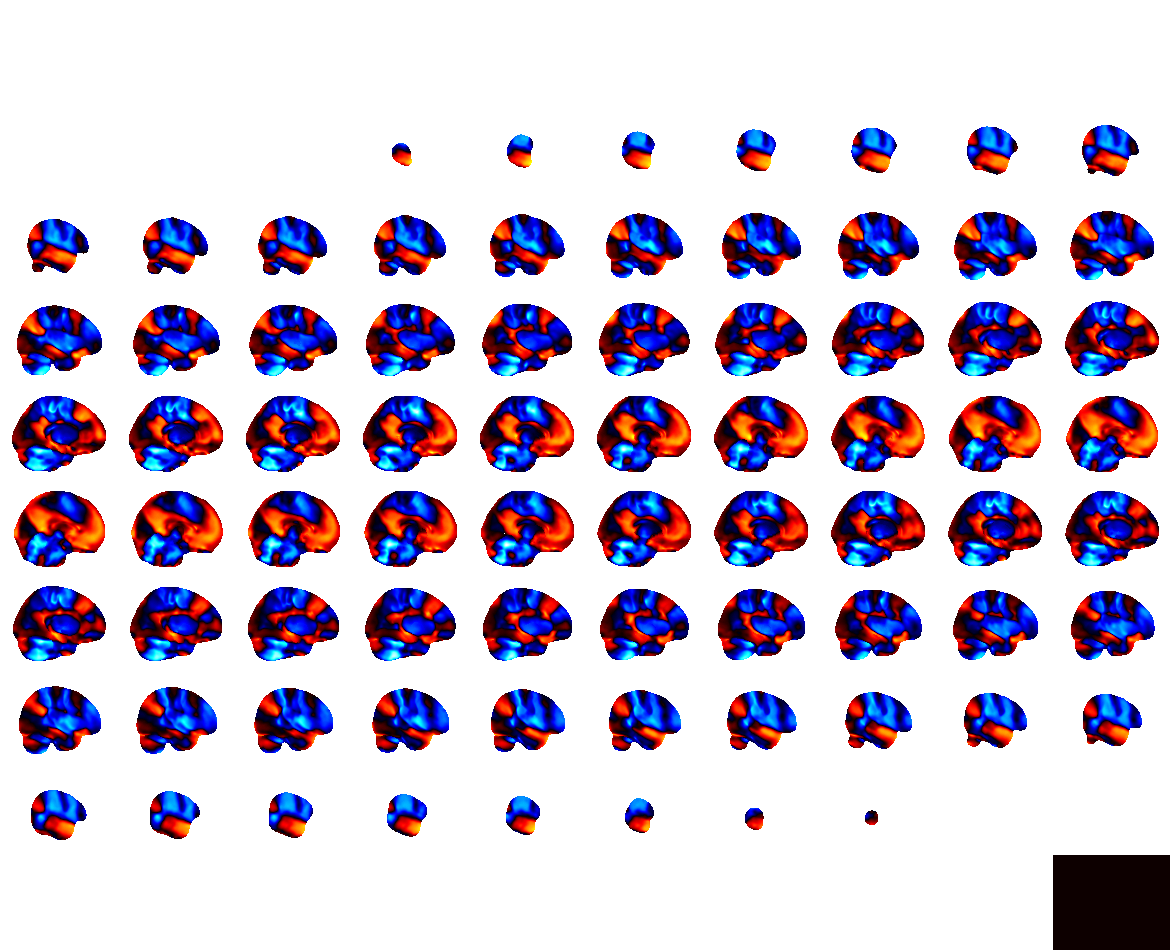

In [16]:
#For visual corroboration of the agreement matrix, plot as many component matrices as necessary
html_two = plotting.view_img(matrix_dict[str(1)], cut_coords=(0,0,0), opacity=.75)
print(os.path.basename(globbed[1]))
html_two


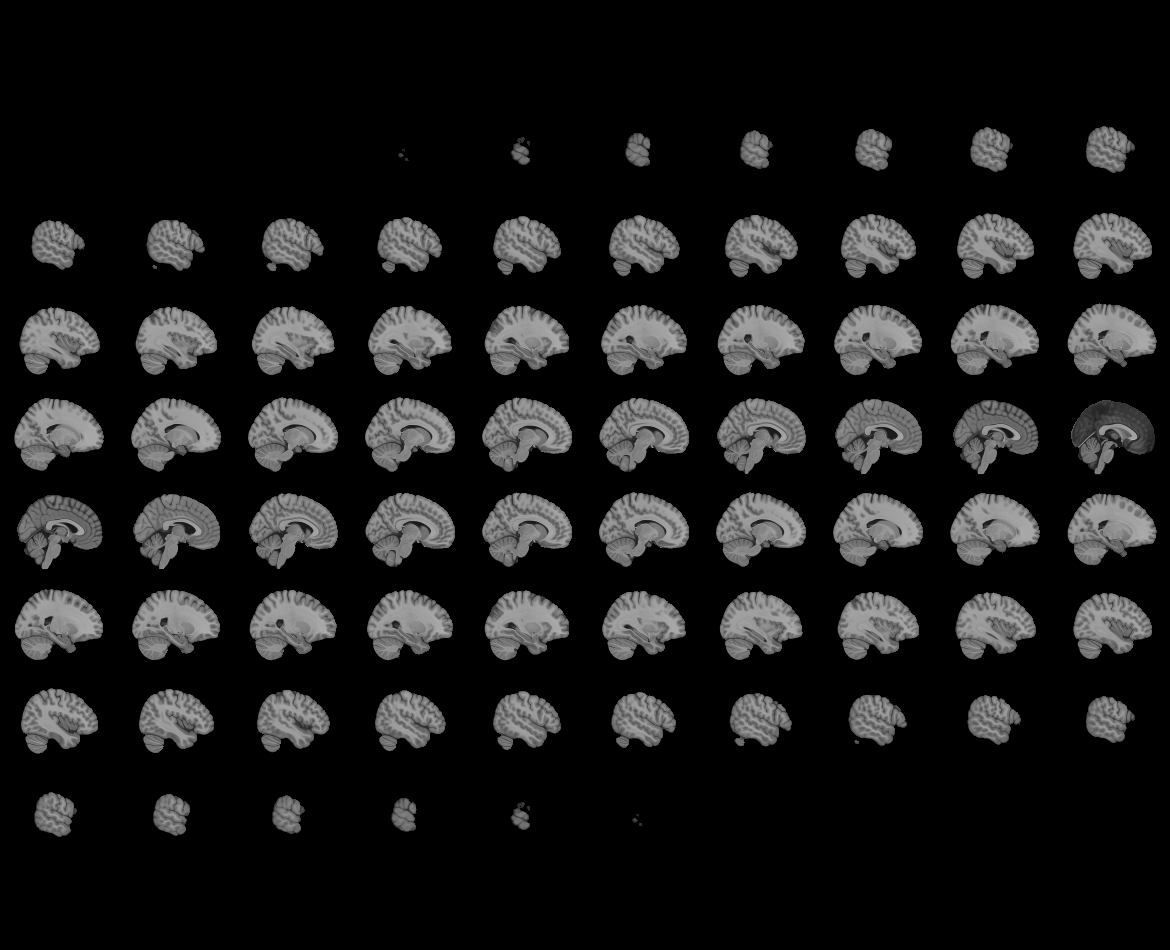
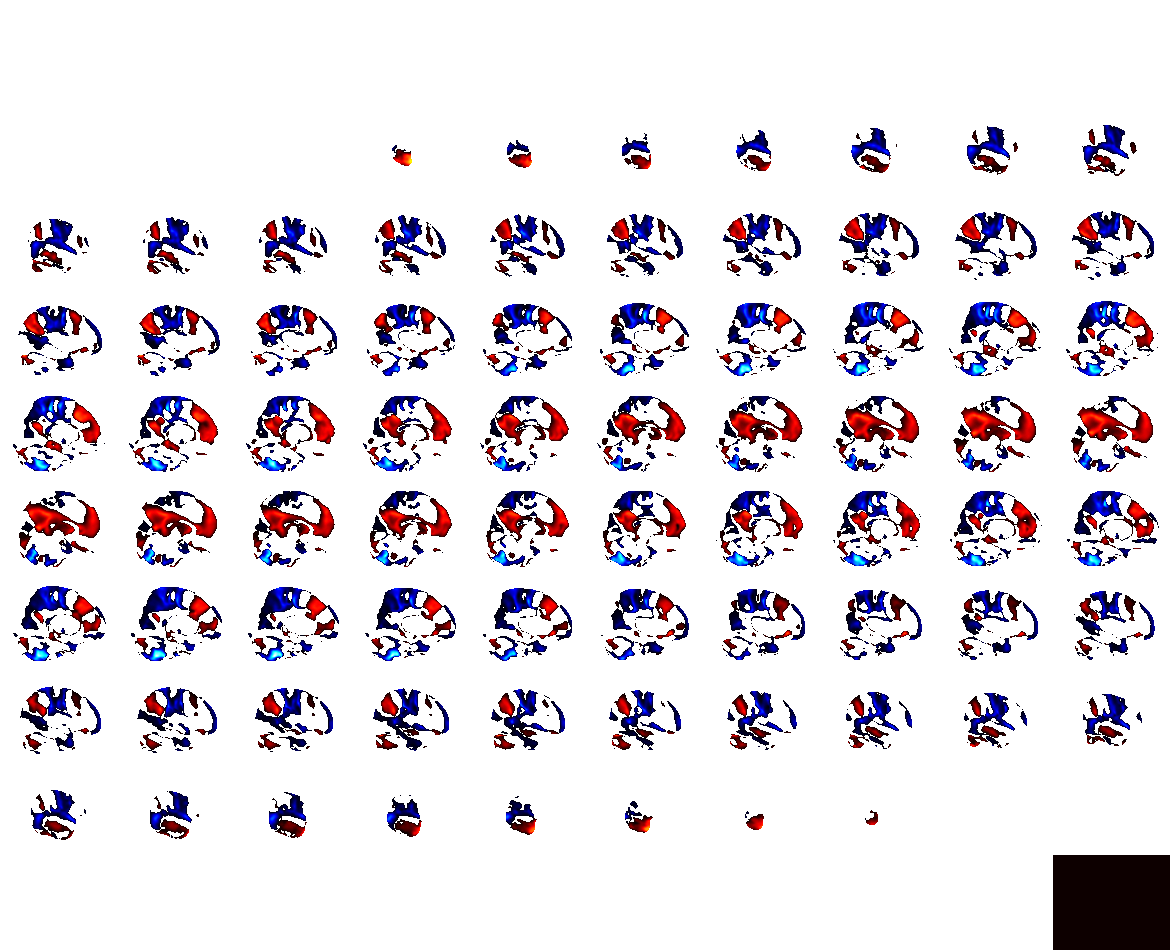

In [17]:
normalized_agree_map = image.new_img_like(mni_mask, agreement_matrix)
normalized_html = plotting.view_img(normalized_agree_map, cut_coords=(0,0,0), opacity=.75)
normalized_html


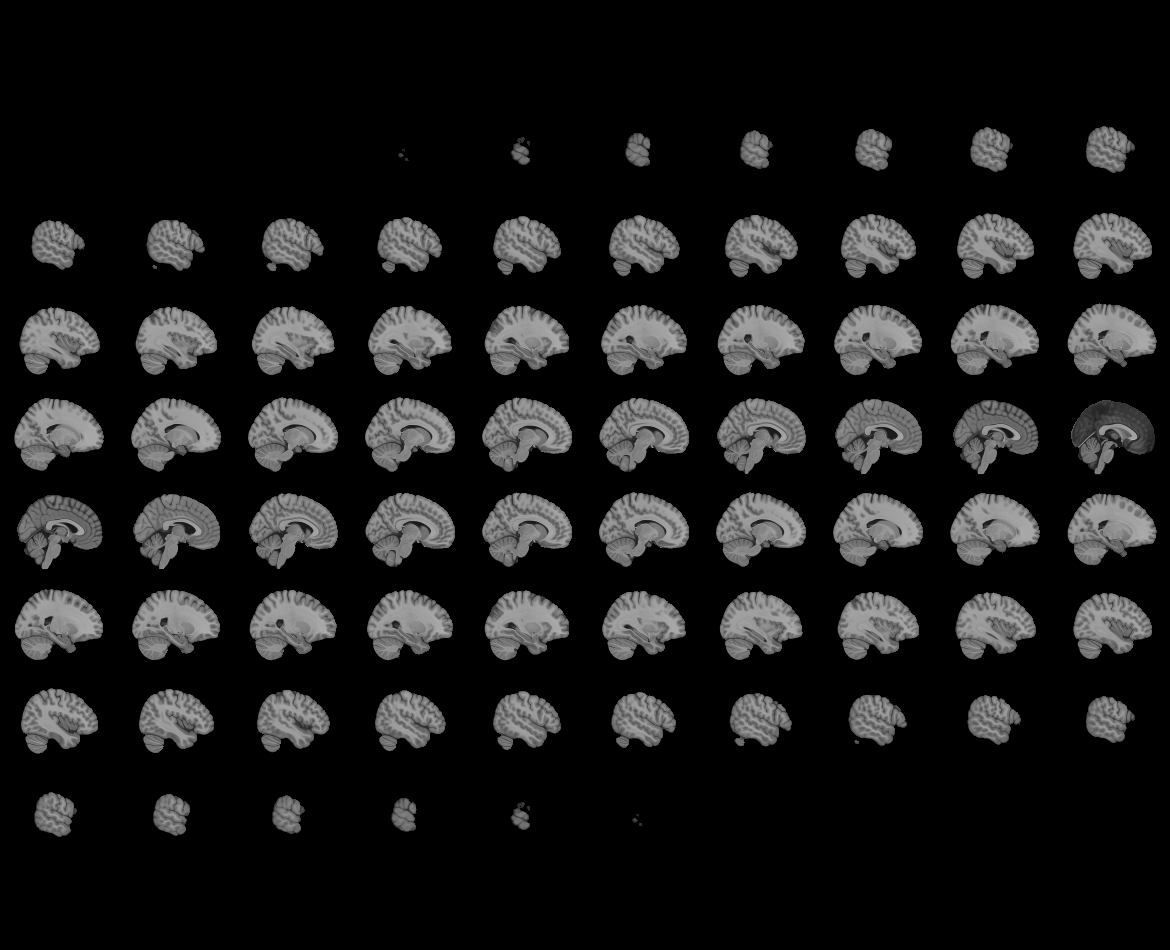
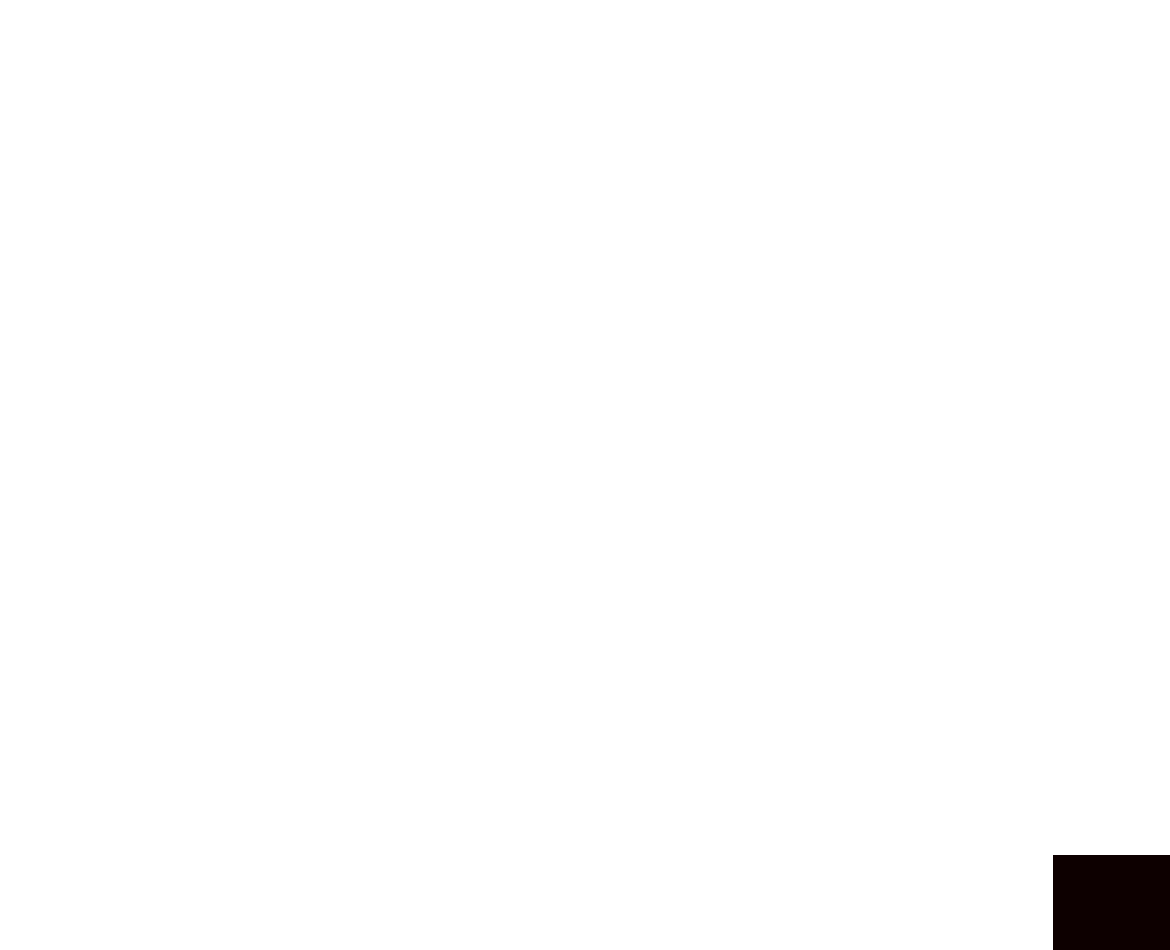

In [18]:
binarized_agree_map = image.new_img_like(mni_mask, binarized_matrix)
binarized_agree_html = plotting.view_img(binarized_agree_map, cut_coords=(0,0,0), opacity=.75)
binarized_agree_html

In [19]:
#Spatial Agreement
agree_df = pd.DataFrame({'geomtric_agreement': [agreement]})
display(agree_df)

,geomtric_agreement
0,0.597677


In [20]:
name = analysis
agree_name = analysis + '.nii'
binary_name = analysis + '_binary.nii'
#make directories
if os.path.isdir(agree_dir) != True:
    os.mkdir(agree_dir)
if os.path.isdir(html_dir) != True:
    os.mkdir(html_dir)

#Save values
agree_df.to_csv(os.path.join(agree_dir, f'{name}_geometric_agreement.csv'))

#Save niftis
normalized_agree_map.to_filename(os.path.join(agree_dir, analysis))
binarized_agree_map.to_filename(os.path.join(agree_dir, binary_name))

#Save htmls
normalized_html.save_as_html(os.path.join(html_dir, agree_name.split('.nii')[0]+'.html'))
binarized_agree_html.save_as_html(os.path.join(html_dir, binary_name.split('.nii')[0]+'.html'))


In [21]:
print('saved to: ', html_dir)

saved to:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/html_networks


In [93]:
##OLD METHOD OF PERFORMING AGREEMENT FUNCTION
#Import data
# rios_matrix = img_one.get_fdata()
# rios_matrix = np.nan_to_num(rios_matrix, nan=0, posinf=0, neginf=0)

# ferg_matrix = img_two.get_fdata()
# ferg_matrix = np.nan_to_num(ferg_matrix,nan=0, posinf=0, neginf=0)

# nonzero_r = np.count_nonzero(rios_matrix)
# nonzero_f = np.count_nonzero(ferg_matrix)

#Find positive values
# rios_p = np.zeros(rios_matrix.shape)
# ferg_p = np.zeros(rios_matrix.shape)
# rios_p[rios_matrix>0] = 1
# ferg_p[ferg_matrix>0] = 1

#Find negative values
# rios_n = np.zeros(rios_matrix.shape)
# ferg_n = np.zeros(rios_matrix.shape)
# rios_n[rios_matrix<0] = -1
# ferg_n[ferg_matrix<0] = -1

#Set non-matching values to 0
# pos_map = rios_p*ferg_p
# neg_map = (-1)*(rios_n*ferg_n) #sets values to 0 and keeps sign negative

# #Preparing final matrices
# multiplied_matrix = ferg_matrix*rios_matrix
# binarized_matrix = pos_map+neg_map

# #Manipulating Matrices and Visualizing Final Product
# multiplied_matrix = (multiplied_matrix/abs(np.max(multiplied_matrix))) #normalization
# agreement_matrix = multiplied_matrix*binarized_matrix #reintroducing signs
# agreement = np.count_nonzero(binarized_matrix)/nonzero_r*100

# neg_map_img = image.new_img_like(mni_mask, neg_map)
# pos_map_img = image.new_img_like(mni_mask, pos_map)
# normalized_agree_map = image.new_img_like(mni_mask, agreement_matrix)
# binary_agree_map = image.new_img_like(mni_mask, binarized_matrix)


# print('---Sanity Check---')
# print('rios total nonzero voxels: ', nonzero_r)
# print('ferguson total nonzero voxels: ', nonzero_f)
# print('nonzero values, normalized matrix: ', np.count_nonzero(agreement_matrix))
# print('nonzero values, binary matrix: ', np.count_nonzero(binarized_matrix))
# print('Percent spatial agreement: ', agreement)